# Learner

> Module containing helper functions and classes around the Learner

In [ ]:
#|default_exp learners

In [ ]:
 #| export
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import torch.nn.functional as F
from operator import attrgetter
import fastcore.all as fc
import math
from fastprogress import progress_bar,master_bar
import torcheval.metrics as tem

In [ ]:
 #| export

class CancelFitException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass


class PublishEvents():
    def __init__(self, name): 
        self.name = name
    
    def __call__(self, decorated_fn):
        def decorated_fn_with_publishing(learner, *args, **kwargs):
            try:
                learner.publish(f'before_{self.name}')
                decorated_fn(learner, *args, **kwargs)
                learner.publish(f'after_{self.name}')
            except globals()[f'Cancel{self.name.title()}Exception']: pass
        return decorated_fn_with_publishing

In [ ]:
 #| export
class Learner():
    def __init__(self, model, dls, loss_fn, optim_class, lr, subs):
        self.model = model
        self.dls = dls
        self.loss_fn = loss_fn
        self.optim_class = optim_class
        self.lr = lr
        self.subs = subs
    
    def fit(self, epochs, train=True, valid=True, subs=[], lr=None):
        for sub in subs: self.subs.append(sub)
        self.n_epochs = epochs
        self.epochs = range(self.n_epochs)
        lr = self.lr if lr is None else lr
        self.opt = self.optim_class(self.model.parameters(), lr)
        try:
            self._fit(train, valid)
        finally:
            for sub in subs: self.subs.remove(sub)
                    
    @PublishEvents('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: 
                self.one_epoch(True)
            if valid:
                with torch.no_grad():
                    self.one_epoch(False)
        
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        self._one_epoch()
        
    @PublishEvents('epoch')
    def _one_epoch(self):
        for self.batch in self.dl: 
            self.one_batch()
    
    @PublishEvents('batch')
    def one_batch(self):
        self.predict()
        self.publish('after_predict')
        self.get_loss()
        self.publish('after_loss')
        if self.model.training:
            self.backward()
            self.publish('after_backward')
            self.step()
            self.publish('after_step')
            self.zero_grad()
        
    def publish(self, event):
        for sub in sorted(self.subs, key=attrgetter('order')):
            method = getattr(sub, event, None)
            if method is not None: method(self)
            
    def predict(self): 
        self.preds = self.model(self.batch[0])
        
    def get_loss(self): 
        self.loss = self.loss_fn(self.preds, self.batch[1])
        
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [ ]:
 #| export
class Subscriber():
    order = 0

In [ ]:
 #|export
class MetricsS(Subscriber):
    def __init__(self, **metrics):
        self.metrics = metrics
        self.loss = tem.Mean()
        
    def before_fit(self, learn): 
        learn.metrics = self
    
    def before_epoch(self, learn):
        for m in self.metrics.values(): m.reset()
        self.loss.reset()
    
    def after_batch(self, learn):
        x,y,*_ = self.to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(self.to_cpu(learn.preds), y)
        self.loss.update(self.to_cpu(learn.loss), weight=len(x))
        
    def after_epoch(self, learn):
        log = {
            'epoch': learn.epoch,
            'mode': 'train' if learn.model.training else 'eval',
            'loss' : f'{self.loss.compute():.3f}'
        }
        for k, v in self.metrics.items():
            log[k] = f'{v.compute():.3f}'
        self.output(log)
        
    def to_cpu(self, x):
        if isinstance(x, list): return (self.to_cpu(el) for el in x)
        return x.detach().cpu()
        
    def output(self, log): print(log)

In [ ]:
 #| export

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
class DeviceS(Subscriber):
    
    def __init__(self, device):
        self.device = device
    
    def before_fit(self, learn):
        learn.model.to(self.device)
    
    def before_batch(self, learn):
        learn.batch = [x.to(self.device) for x in learn.batch]

In [ ]:
 #| export
class LRFindS(Subscriber):
    
    def __init__(self, mult=1.25):
        self.mult = mult
        self.min = math.inf
        
    def before_epoch(self, learn):
        if not learn.model.training: raise CancelFitException
        self.losses = []
        self.lrs = []
    
    def after_loss(self, learn):
        lr = learn.opt.param_groups[0]['lr']
        self.lrs.append(lr)
        loss = learn.loss.detach().cpu()
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] = lr * self.mult
        
    def plot(self):
        plt.plot(lrfind.lrs, lrfind.losses)
        plt.xscale('log')

In [ ]:
 #| export
class MomentumLearner(Learner):
    
    def __init__(self, model, dls, loss_fn, optim_class, lr, subs, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_fn, optim_class, lr, subs)
        
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

In [ ]:
 #| export

#https://github.com/fastai/fastprogress/blob/master/fastprogress/core.py
def in_colab():
    "Check if the code is running in Google Colaboratory"
    try:
        from google import colab
        return True
    except: return False
    
#https://github.com/fastai/fastprogress/blob/master/fastprogress/core.py
def in_notebook():
    "Check if the code is running in a jupyter notebook"
    if in_colab(): return True
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell': # Jupyter notebook, Spyder or qtconsole
            import IPython
            #IPython version lower then 6.0.0 don't work with output you update
            return IPython.__version__ >= '6.0.0'
        elif shell == 'TerminalInteractiveShell': return False  # Terminal running IPython
        else: return False  # Other type (?)
    except NameError: return False      # Probably standard Python interpreter

IN_NOTEBOOK = in_notebook()

class ProgressS(Subscriber):
    order = MetricsS.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics.output = self.output
        self.losses = []
        self.val_losses = []

    def output(self, d):
        if IN_NOTEBOOK:         # added this because of an automatic test failing in cmd mode
            if self.first:
                self.mbar.write(list(d), table=True)
                self.first = False
            self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.model.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.model.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.loss.compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])


Example usage:

In [ ]:
from datasets import load_dataset,load_dataset_builder

from nntrain.dataloaders import DataLoaders, hf_ds_collate_fn

In [ ]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
hf_dd = load_dataset(name)

bs = 1024
n_in = 28*28
n_h = 50
n_out = 10
lr = 0.01

dls = DataLoaders.from_hf_dd(hf_dd, batch_size=bs)

Reusing dataset fashion_mnist (/root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def get_model():
    layers = [nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_out)]
    return nn.Sequential(*layers)

epoch,mode,loss,accuracy
0,train,1.763,0.458
0,eval,1.151,0.647
1,train,0.949,0.669
1,eval,0.846,0.685
2,train,0.777,0.719
2,eval,0.748,0.725
3,train,0.697,0.757
3,eval,0.683,0.762
4,train,0.643,0.780
4,eval,0.641,0.778


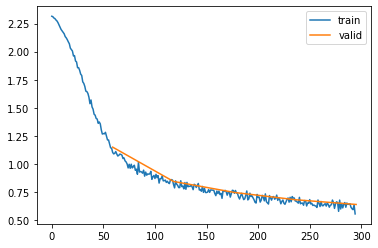

In [ ]:
metrics = MetricsS(accuracy=tem.MulticlassAccuracy())
progress = ProgressS(True)
device = DeviceS(device)

l = MomentumLearner(get_model(), dls, F.cross_entropy, torch.optim.SGD, lr, [metrics, progress, device])
l.fit(5)

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()